In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp

### 1.Загрузка данных

In [67]:
df = pd.read_csv('../../../../data/Iris.csv', index_col='Id')
print(df.count())
df.head()

SepalLengthCm    150
SepalWidthCm     150
PetalLengthCm    150
PetalWidthCm     150
Species          150
dtype: int64


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


### 2.Предварительная обработка

In [12]:
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

In [57]:
class FillNa(TransformerMixin, BaseEstimator):
    def fit(self, df: pd.DataFrame, y=None):
        return self
    
    def transform(self, df: pd.DataFrame, y=None) -> pd.DataFrame:
        return df.interpolate(method='cubic').fillna(method='pad').dropna()
    

class DropOutlet(TransformerMixin, BaseEstimator):
    def fit(self, df: pd.DataFrame, y=None):
        self.std = df.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, df: pd.DataFrame, y=None) -> pd.DataFrame:
        df_cols = df[self.columns]
        return df[ (df_cols - df_cols.mean()).abs() <= 3*self.std].dropna()
    
    
class PandasToNumpy(BaseEstimator):
    def fit(self, data : pd.DataFrame, y=None):
        return self
    
    def transform(self, data: pd.DataFrame, y=None) -> np.ndarray:
        return data.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        return df.toarray()
    
    
class ModifyLabelEncoder(preprocessing.LabelEncoder):
    def fit(self, df, y=None):
        return super().fit(df)
    
    def transform(self, df, y=None):
        return super().transform(df)
    
    def fit_transform(self, df, y=None):
        return super().fit_transform(df)
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 размерности массива в нужной оси 
    """
    def __init__(self, axis):
        self.axis = axis
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        return np.expand_dims(df, axis=self.axis)
        
    

In [58]:
x_data = df[df.columns[:-1]].copy()
# в числовых данных getdummies не даст эффекта АСТАНАВИТЕС

In [59]:
y_data = df[df.columns[-1]].copy()

In [60]:
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa())
])
pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet())
])

outletless_data_x = pipe_outlet.fit_transform(x_data)

In [61]:
outletless_data_y = y_data[fill_na_pipe.transform(y_data).index.isin(outletless_data_x.index) ]

In [62]:
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

In [63]:
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False)),
])

In [64]:
number_data_x = pipe_x.fit_transform(outletless_data_x)
number_data_y = pipe_y.fit_transform(outletless_data_y)

print(number_data_x.shape, number_data_y.shape)

(149, 4) (149, 3)


c:\users\apc\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [65]:
number_data_x[:10,:], number_data_y[::10]

(array([[0.22222222, 0.68181818, 0.06779661, 0.04166667],
        [0.16666667, 0.45454545, 0.06779661, 0.04166667],
        [0.11111111, 0.54545455, 0.05084746, 0.04166667],
        [0.08333333, 0.5       , 0.08474576, 0.04166667],
        [0.19444444, 0.72727273, 0.06779661, 0.04166667],
        [0.30555556, 0.86363636, 0.11864407, 0.125     ],
        [0.08333333, 0.63636364, 0.06779661, 0.08333333],
        [0.19444444, 0.63636364, 0.08474576, 0.04166667],
        [0.02777778, 0.40909091, 0.06779661, 0.04166667],
        [0.16666667, 0.5       , 0.08474576, 0.        ]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]))

### 3.Построение нейронной сети без смс и регистрации

In [76]:
x_train = number_data_x
y_train = number_data_y

In [70]:
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

In [77]:
model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=x_train.shape[1]))
model.add(Dense(y_train.shape[1], activation=activations.softmax))

model.compile(optimizer='adam', loss = categorical_crossentropy, metrics=[categorical_accuracy])

In [79]:
model.fit(x_train, y_train, verbose=2, epochs=100, batch_size=3)

Epoch 1/100
 - 0s - loss: 1.0179 - categorical_accuracy: 0.4497
Epoch 2/100
 - 0s - loss: 0.9514 - categorical_accuracy: 0.6779
Epoch 3/100
 - 0s - loss: 0.8870 - categorical_accuracy: 0.6644
Epoch 4/100
 - 0s - loss: 0.8250 - categorical_accuracy: 0.6711
Epoch 5/100
 - 0s - loss: 0.7676 - categorical_accuracy: 0.6644
Epoch 6/100
 - 0s - loss: 0.7149 - categorical_accuracy: 0.6644
Epoch 7/100
 - 0s - loss: 0.6609 - categorical_accuracy: 0.6644
Epoch 8/100
 - 0s - loss: 0.6154 - categorical_accuracy: 0.6644
Epoch 9/100
 - 0s - loss: 0.5818 - categorical_accuracy: 0.6644
Epoch 10/100
 - 0s - loss: 0.5534 - categorical_accuracy: 0.6644
Epoch 11/100
 - 0s - loss: 0.5296 - categorical_accuracy: 0.6779
Epoch 12/100
 - 0s - loss: 0.5113 - categorical_accuracy: 0.6779
Epoch 13/100
 - 0s - loss: 0.4933 - categorical_accuracy: 0.7114
Epoch 14/100
 - 0s - loss: 0.4782 - categorical_accuracy: 0.7315
Epoch 15/100
 - 0s - loss: 0.4642 - categorical_accuracy: 0.7248
Epoch 16/100
 - 0s - loss: 0.4522 

Выглядит как что-то переобученное (что ожидаемо на подобном размере)

In [82]:
model.evaluate(x_train, y_train)

149/149 [==============================] - 0s 60us/step


[0.10604601868447042, 0.9664429534201654]

##### 5. Пстроение усложнённого вариианта НС

In [81]:
from keras import callbacks

In [85]:
xy_data = np.hstack( (number_data_x, number_data_y) ).transpose( (0,1))
np.random.shuffle(xy_data)

point_split = round(xy_data.shape[0] * 0.8)
train_data = xy_data[:point_split]
test_data = xy_data[point_split:]

print(f'Всего данных: {xy_data.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')

x_train = train_data[:, :number_data_x.shape[1] ]
y_train = train_data[:, :number_data_y.shape[1] ]

print(f'Размер данные для тренировки (входных): {x_train.shape}')
print(f'Размер данные для тренировки (выходных): {y_train.shape}')

x_test = test_data[:, :number_data_x.shape[1] ]
y_test = test_data[:, :number_data_y.shape[1] ]

print(f'Размер данные для теста (входных): {x_test.shape}')
print(f'Размер данные для теста (выходных): {x_test.shape}')

Всего данных: 149
Тренировочных данных: 119
Тестовых данных: 30
Размер данные для тренировки (входных): (119, 4)
Размер данные для тренировки (выходных): (119, 3)
Размер данные для теста (входных): (30, 4)
Размер данные для теста (выходных): (30, 4)


In [90]:
def make_nn(input_len, output_len):
    model = Sequential(layers=(
        Dense(10, activation='relu', input_dim=input_len),
        Dense(output_len, activation=activations.softmax)
        )
    )
    model.compile(optimizer='adam', loss = categorical_crossentropy, metrics=[categorical_accuracy])
    return model

In [91]:
model = make_nn(x_train.shape[1], y_train.shape[1])

print('Начинаем обучение')
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(x_test,y_test),
    callbacks=[
        callbacks.History()
    ]
)

Начинаем обучение
Train on 119 samples, validate on 30 samples
Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.5670 - categorical_accuracy: 0.5714 - val_loss: 1.3061 - val_categorical_accuracy: 0.7333
Epoch 2/100
119/119 [==============================] - 0s 892us/step - loss: 1.5382 - categorical_accuracy: 0.8319 - val_loss: 1.3007 - val_categorical_accuracy: 0.6667
Epoch 3/100
119/119 [==============================] - 0s 834us/step - loss: 1.5289 - categorical_accuracy: 0.7479 - val_loss: 1.2953 - val_categorical_accuracy: 0.5333
Epoch 4/100
119/119 [==============================] - 0s 734us/step - loss: 1.5201 - categorical_accuracy: 0.7311 - val_loss: 1.2889 - val_categorical_accuracy: 0.5667
Epoch 5/100
119/119 [==============================] - 0s 784us/step - loss: 1.5109 - categorical_accuracy: 0.7479 - val_loss: 1.2815 - val_categorical_accuracy: 0.6000
Epoch 6/100
119/119 [==============================] - 0s 876us/step - loss: 1.5016 - categori

119/119 [==============================] - 0s 642us/step - loss: 1.4280 - categorical_accuracy: 0.9412 - val_loss: 1.1941 - val_categorical_accuracy: 0.9667
Epoch 97/100
119/119 [==============================] - 0s 642us/step - loss: 1.4279 - categorical_accuracy: 0.9244 - val_loss: 1.1940 - val_categorical_accuracy: 0.9667
Epoch 98/100
119/119 [==============================] - 0s 941us/step - loss: 1.4279 - categorical_accuracy: 0.9496 - val_loss: 1.1936 - val_categorical_accuracy: 0.9667
Epoch 99/100
119/119 [==============================] - 0s 1ms/step - loss: 1.4278 - categorical_accuracy: 0.9412 - val_loss: 1.1936 - val_categorical_accuracy: 0.9667
Epoch 100/100
119/119 [==============================] - 0s 846us/step - loss: 1.4278 - categorical_accuracy: 0.9580 - val_loss: 1.1937 - val_categorical_accuracy: 0.9667


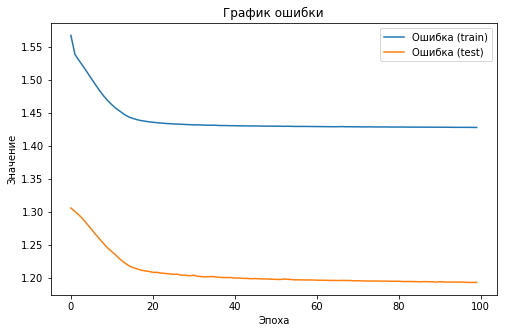

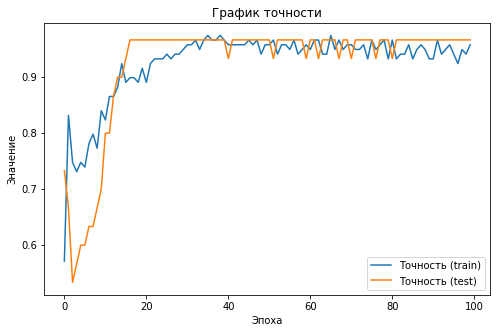

In [94]:
plt.figure(0, figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(8,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('График точности')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Точность (train)', 'Точность (test)'])

In [95]:
model = make_nn(number_data_x.shape[1], number_data_y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_x,
    y=number_data_y,
    batch_size=3,
    epochs=100,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 119 samples, validate on 30 samples
Epoch 1/100
119/119 [==============================] - 1s 5ms/step - loss: 1.1377 - categorical_accuracy: 0.4118 - val_loss: 1.3580 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
119/119 [==============================] - 0s 1ms/step - loss: 1.0854 - categorical_accuracy: 0.4118 - val_loss: 1.3584 - val_categorical_accuracy: 0.0000e+00
Epoch 3/100
119/119 [==============================] - 0s 903us/step - loss: 1.0447 - categorical_accuracy: 0.4118 - val_loss: 1.3681 - val_categorical_accuracy: 0.0000e+00
Epoch 4/100
119/119 [==============================] - 0s 1ms/step - loss: 1.0100 - categorical_accuracy: 0.4622 - val_loss: 1.3749 - val_categorical_accuracy: 0.0000e+00
Epoch 5/100
119/119 [==============================] - 0s 1ms/step - loss: 0.9765 - categorical_accuracy: 0.5798 - val_loss: 1.3708 - val_categorical_accuracy: 0.0000e+00
Epoch 6/100
119/119 [==============================] - 0s 963us/step - loss

Epoch 48/100
119/119 [==============================] - 0s 729us/step - loss: 0.2289 - categorical_accuracy: 0.9496 - val_loss: 0.6947 - val_categorical_accuracy: 0.5000
Epoch 49/100
119/119 [==============================] - 0s 742us/step - loss: 0.2246 - categorical_accuracy: 0.9496 - val_loss: 0.6835 - val_categorical_accuracy: 0.5333
Epoch 50/100
119/119 [==============================] - 0s 729us/step - loss: 0.2198 - categorical_accuracy: 0.9496 - val_loss: 0.7247 - val_categorical_accuracy: 0.5000
Epoch 51/100
119/119 [==============================] - 0s 713us/step - loss: 0.2199 - categorical_accuracy: 0.9496 - val_loss: 0.6990 - val_categorical_accuracy: 0.5000
Epoch 52/100
119/119 [==============================] - 0s 742us/step - loss: 0.2126 - categorical_accuracy: 0.9496 - val_loss: 0.7507 - val_categorical_accuracy: 0.4333
Epoch 53/100
119/119 [==============================] - 0s 859us/step - loss: 0.2059 - categorical_accuracy: 0.9496 - val_loss: 0.6398 - val_categoric

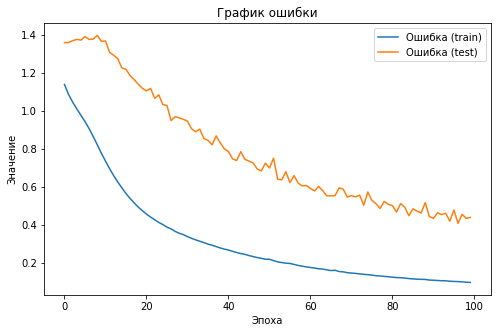

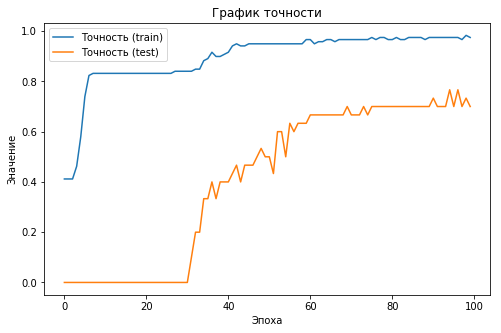

In [96]:
plt.figure(0, figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(8,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('График точности')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Точность (train)', 'Точность (test)'])

In [1]:
model = make_nn(number_data_x.shape[1], number_data_y.shape[1])

print('Начинаем обучение')
history = model.fit(
    x=number_data_x,
    y=number_data_y,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping( monitor='val_categorical_accuracy',
                                mode='max',
                                patience=50,
                               min_delta=0.01)
    ]
)

NameError: name 'make_nn' is not defined

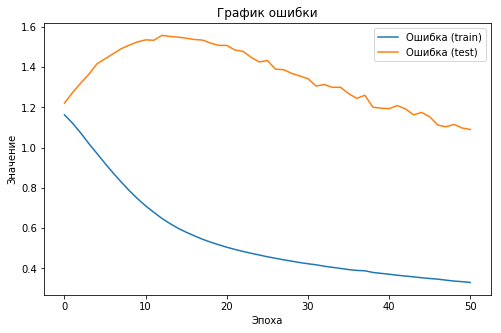

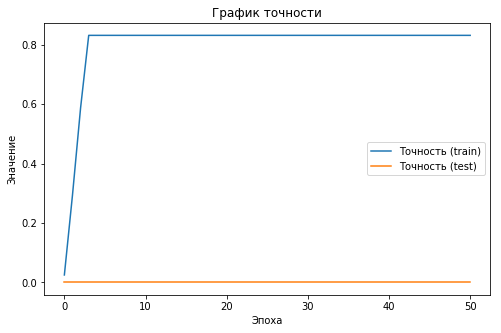

In [99]:
plt.figure(0, figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(8,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('График точности')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Точность (train)', 'Точность (test)'])

In [100]:
from pathlib import Path
from os import remove

In [101]:
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'

def make_save_points(name='save_points', file_name=file_name):
    checkpoints_dir = Path('./').joinpath('save_points')
    checkpoints_dir.mkdir(exist_ok=True)
    
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляю {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [102]:
print('Начинаем обучение')
history = make_nn(x_train.shape[1], y_train.shape[1]).fit(
    x=x_train,
    y=y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        mode='max',
        patience=50,
        min_delta=0.01),
        callbacks.ModelCheckpoint(
            make_save_points(file_name=file_name),
            monitor='val_categorical_accuracy',
            save_best_only=True,
            period=5,
            mode='max'
        )
    ]
)

Начинаем обучение
Train on 95 samples, validate on 24 samples
Epoch 1/300
95/95 [==============================] - 1s 7ms/step - loss: 1.5734 - categorical_accuracy: 0.3474 - val_loss: 1.5477 - val_categorical_accuracy: 0.3750
Epoch 2/300
95/95 [==============================] - 0s 1ms/step - loss: 1.5506 - categorical_accuracy: 0.3474 - val_loss: 1.5327 - val_categorical_accuracy: 0.4167
Epoch 3/300
95/95 [==============================] - 0s 1ms/step - loss: 1.5363 - categorical_accuracy: 0.5474 - val_loss: 1.5214 - val_categorical_accuracy: 0.6667
Epoch 4/300
95/95 [==============================] - 0s 867us/step - loss: 1.5246 - categorical_accuracy: 0.7895 - val_loss: 1.5112 - val_categorical_accuracy: 0.8333
Epoch 5/300
95/95 [==============================] - 0s 783us/step - loss: 1.5142 - categorical_accuracy: 0.8632 - val_loss: 1.5017 - val_categorical_accuracy: 0.9167
Epoch 6/300
95/95 [==============================] - 0s 1ms/step - loss: 1.5050 - categorical_accuracy: 0.926

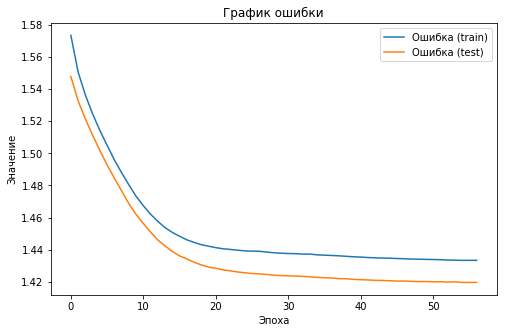

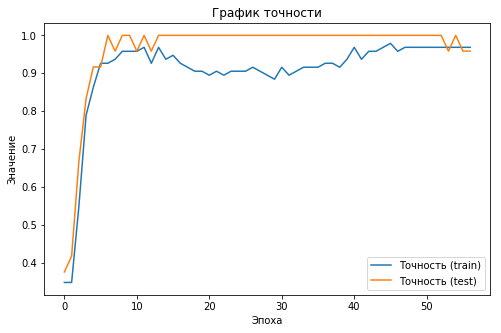

In [103]:
plt.figure(0, figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)'])

plt.figure(1, figsize=(8,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('График точности')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Точность (train)', 'Точность (test)'])

In [105]:
from keras.models import load_model

loaded_model = load_model('./save_points/nn_model_loss-1.47_val_loss-1.46_acc-0.96_val_acc-1.00.hdf5')

print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(x_train, y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(x_test, y_test)[1]}')
predict = loaded_model.predict_classes(x_test)
predict


119/119 [==============================] - 0s 1ms/step
Точность предсказания на тренировочных данных 0.9663865546218487
30/30 [==============================] - 0s 132us/step
Точность предсказания на тестовых данных 1.0


array([0, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0,
       1, 1, 2, 2, 2, 2, 1, 2], dtype=int64)

In [106]:
pipe_y.named_steps['label_encoder'].inverse_transform(predict)

array(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica', 'Iris-versicolor', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-versicolor', 'Iris-virginica', 'Iris-virginica',
       'Iris-versicolor', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-versicolor', 'Iris-virginica'],
      dtype=object)

In [107]:
loaded_model.predict(x_train)

array([[0.3411029 , 0.27681822, 0.38207892],
       [0.2561764 , 0.51394224, 0.22988138],
       [0.2245183 , 0.5126409 , 0.26284084],
       [0.26272684, 0.47104043, 0.26623282],
       [0.34943023, 0.29838577, 0.35218397],
       [0.2251585 , 0.5950273 , 0.17981414],
       [0.3537024 , 0.30652285, 0.3397748 ],
       [0.26101473, 0.4666564 , 0.27232894],
       [0.31363913, 0.33632627, 0.3500345 ],
       [0.30778167, 0.318669  , 0.37354934],
       [0.29392105, 0.3546234 , 0.35145563],
       [0.24221875, 0.54408395, 0.2136973 ],
       [0.27585617, 0.49274945, 0.23139437],
       [0.3668954 , 0.25644675, 0.37665784],
       [0.32565948, 0.29167044, 0.3826701 ],
       [0.35527998, 0.2660851 , 0.37863496],
       [0.2857292 , 0.31986287, 0.3944079 ],
       [0.3436044 , 0.27482918, 0.3815665 ],
       [0.24227875, 0.4990491 , 0.25867212],
       [0.23480767, 0.49872485, 0.26646745],
       [0.2314858 , 0.5488242 , 0.21968997],
       [0.3124984 , 0.34046525, 0.34703636],
       [0.

In [124]:
def make_mashgird(x,y,h=0.2):
    x_min, x_max = x.min() -1, x.max() +1
    y_min, y_max = y.min() -1, y.max() +1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    return xx,yy
    
def plot_contours(ax, clf, xx,yy, **params):
    z = clf(xx, yy)
    z = z.reshape(xx.shape)
    out = ax.contourf(xx, yy, z, **params)
    return out
    

(149, 2)


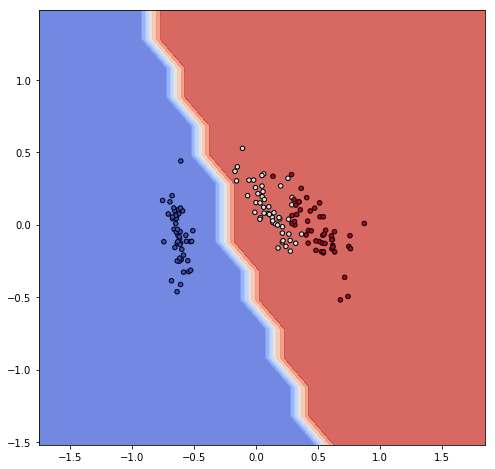

In [128]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder())
])

y = pipe_y_mini.fit_transform(outletless_data_y)
x = number_data_x

pca = PCA(n_components=2)

_x = pca.fit_transform(x)
print(_x.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(),yy.ravel()]))

x0, x1 = _x[:, 0], _x[:, 1]
xx, yy = make_mashgird(x0, x1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(x0,x1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')